In [16]:
#####Factorization meets the item Embedding#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns

#np.random.seed(98537)

(array([ 24.,  57., 150., 279., 409., 585., 582., 562., 594., 441., 365.,
        289., 184., 176.,  84.,  98.,  42.,  31.,  17.,  10.,  12.,   4.,
          2.,   1.,   2.]),
 array([ 22. ,  31.6,  41.2,  50.8,  60.4,  70. ,  79.6,  89.2,  98.8,
        108.4, 118. , 127.6, 137.2, 146.8, 156.4, 166. , 175.6, 185.2,
        194.8, 204.4, 214. , 223.6, 233.2, 242.8, 252.4, 262. ]),
 <a list of 25 Patch objects>)

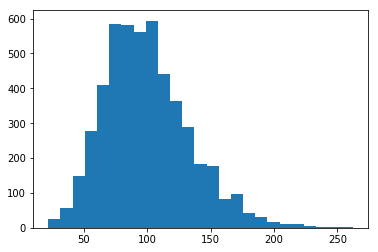

In [17]:
####データの生成####
##データの設定
s = 2
k = 10
k_vec = np.repeat(1, k)
hh = 5000
item = 3000
pt = np.random.poisson(np.random.gamma(10.0, 1/0.1, hh), hh)
hhpt = np.sum(pt)
plt.hist(pt, bins=25)

In [18]:
##IDとインデックスの設定
#IDの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(hhpt))
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = index[d_id==i]
d_dt = sparse.coo_matrix((np.repeat(1, hhpt), (d_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [19]:
#素性ベクトルを生成
k1 = 5; k2 = 6; k3 = 5
x1 = np.abs(np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1)))
x2 = np.zeros((hhpt, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, hhpt)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3), axis=1)   #すべての説明変数を結合
x_col = x.shape[1]

In [20]:
##アイテムの割当を生成
#トピック割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.225, item), topic)
theta = np.random.dirichlet(np.repeat(0.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[d_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(item))
item_dt = sparse.coo_matrix((np.repeat(1, hhpt), (item_id, range(hhpt))), shape=(item, hhpt)).tocsr()   #スパース行列の設定
item_n = np.array(np.sum(item_dt, axis=1)).reshape(-1)

0
1000
2000
3000
4000


In [23]:
##応答変数を生成
rp = 0
while True:
    rp = 0

    ##モデルパラメータを生成
    #事前分布のパラメータ
    alpha_u = np.repeat(0, k)
    alpha_v = np.repeat(0, k)
    tau = np.array([1.5])
    Cov_u = np.diag(np.repeat(0.5, k))
    Cov_v1 = np.diag(np.repeat(0.5, k))
    Cov_v2 = np.diag(np.repeat(0.5, k))
    alpha_ut = alpha_u.copy(); alpha_vt = alpha_v.copy()
    taut = tau.copy(); Cov_ut = Cov_u.copy(); Cov_vt1 = Cov_v1.copy(); Cov_vt2 = Cov_v2.copy()
    
    #MFのパラメータを生成
    beta = np.append(-1.0, np.random.normal(0, 0.7, x_col-1))
    theta = np.random.multivariate_normal(alpha_u, Cov_u, hh)
    Sigma = np.array([1.0])
    betat = beta.copy(); thetat = theta.copy(); Sigmat = Sigma.copy()

    #item embeddingのパラメータ
    alpha = np.random.normal(-0.3, tau, item)
    gamma = np.random.multivariate_normal(np.repeat(0, k), Cov_v1, hh)
    omega = np.random.multivariate_normal(np.repeat(0, k), Cov_v2, hh)
    alphat = alpha.copy(); gammat = gamma.copy(); omegat = omega.copy()

    ##アイテム購買応答変数を生成
    #期待値を設定
    mu1 = np.dot(x, beta) + np.sum(theta[d_id, ] * gamma[item_id, ], axis=1)

    #正規分布からバイナリー変数を生成
    u1 = np.random.normal(mu1, Sigma, hhpt)
    y1 = np.array(u1 > 0, dtype="int")
    y_vec1 = y1[:, np.newaxis]
    
    #break条件
    print(np.mean(y1))
    if (np.mean(y1) > 0.2) & (np.mean(y1) < 0.4):
        break

0.15866201520218423
0.3181044011707568


In [25]:
##item Embeddingの応答変数を生成
#データの設定
n = 5
no = np.arange(item)
rate = item_n / np.sum(item_n)
y2_list = [j for j in range(item)]
Embedding_id_list1 = [j for j in range(item)]
Embedding_id_list2 = [j for j in range(item)]

#アイテムの共起関係を生成
for j in range(item):
    if j%1000==0:
        print(j)
    random_id = np.random.choice(no, item*n, p=rate)
    mu2 = alpha[j] + alpha[random_id] + np.sum(gamma[np.repeat(j, item*n), ] * omega[random_id, ], axis=1)
    u2 = np.random.normal(mu2, Sigma, item*n)
    y2 = np.array(u2 > 0, dtype="int")
 
    #負例サンプリングでアイテムを生成
    index_y1 = np.array(np.where(y2==1)[0], dtype="int")
    index_y0 = np.array(np.where(y2==0)[0], dtype="int")
    y2_list[j] = np.append(np.repeat(1, item_n[j]), np.repeat(0, item_n[j]*s))
    Embedding_id_list1[j] = np.repeat(j, y2_list[j].shape[0])
    Embedding_id_list2[j] = np.append(random_id[np.random.choice(index_y1, item_n[j], replace=True)], 
                                      random_id[np.random.choice(index_y0, item_n[j]*s, replace=True)])

0
1000
2000


In [27]:
#リストを変換
Embedding_id1 = np.array(list(itertools.chain(*[Embedding_id_list1[j] for j in range(item)])))
Embedding_id2 = np.array(list(itertools.chain(*[Embedding_id_list2[j] for j in range(item)])))
y2 = np.array(list(itertools.chain(*[y2_list[j] for j in range(item)])))
N = y2.shape[0]
del Embedding_id_list1, Embedding_id_list2, y2_list

In [28]:
#Embeddingのインデックスを設定
Embedding_list1 = [j for j in range(item)]
Embedding_list2 = [j for j in range(item)]
for j in range(item):
    Embedding_list1[j] = np.array(np.where(Embedding_id1==j)[0], dtype="int")
    Embedding_list2[j] = np.array(np.where(Embedding_id2==j)[0], dtype="int")

In [ ]:
##テストデータの生成



In [29]:
####ギブスサンプリングでFactorization meets the item Embeddingを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [30]:
##アルゴリズムの設定
LL1 = -100000000   #対数尤度の初期値
R = 2000
keep = 2  
iter = 0
burnin = 500/keep
disp = 10

In [41]:
##事前分布の設定
#階層モデルの事前分布
delta = np.repeat(0, k)
nu = 1
V = 0.1 * np.diag(np.ones(k))
s0 = 0.1
v0 = 0.1

#素性ベクトルの事前分布
Lambda = np.repeat(0, x_col) 
kappa = np.diag(np.repeat(100, x_col))
inv_kappa = np.linalg.inv(kappa)

In [48]:
##パラメータの真値
#階層モデルの事前分布の真値
alpha_u = alpha_ut.copy()
alpha_v = alpha_vt.copy()
tau = taut.copy()
Cov_u = Cov_ut.copy()
Cov_v1 = Cov_vt1.copy()
Cov_v2 = Cov_vt2.copy()
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v1 = np.linalg.inv(Cov_v1)
inv_Cov_v2 = np.linalg.inv(Cov_v2)

#MFのパラメータの真値
beta = betat.copy()
theta = thetat.copy()
Sigma = np.array([1.0])

#item embeddingのパラメータの真値
alpha = alphat.copy()
gamma = gammat.copy()
omega = omegat.copy()

In [38]:
##パラメータの初期値
#階層モデルの事前分布の初期値
alpha_u = np.repeat(0, k)
alpha_v = np.repeat(0, k)
tau = np.array([1.0])
Cov_u = np.diag(np.repeat(0.1, k))
Cov_v1 = np.diag(np.repeat(0.1, k))
Cov_v2 = np.diag(np.repeat(0.1, k))
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v1 = np.linalg.inv(Cov_v1)
inv_Cov_v2 = np.linalg.inv(Cov_v2)

#MFのパラメータの初期値
beta = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x)), x.T), y1)
theta = np.random.multivariate_normal(alpha_u, Cov_u, hh)
Sigma = np.array([1.0])

#item embeddingのパラメータの初期値
alpha1 = np.random.normal(0, 0.5, item)
alpha2 = np.random.normal(0, 0.5, item)
gamma = np.random.multivariate_normal(alpha_v, Cov_v1, hh)
omega = np.random.multivariate_normal(alpha_v, Cov_v2, hh)

array([0, 0, 0, ..., 1, 0, 0])

In [43]:
##データの設定
#データの定数
xx = np.dot(x.T, x)
inv_xx = np.linalg.inv(xx + inv_kappa)

#切断領域を定義
a1 = (1-y1)*(-100) + y1*0
b1 = y1*100 + (1-y1)*0
a2 = (1-y2)*(-100) + y2*0
b2 = y2*100 + (1-y2)*0

In [47]:
##対数尤度の基準値
#1パラメータでの対数尤度
LLst = np.sum(y1*np.log(np.mean(y1))) + np.sum((1-y1)*np.log(np.mean(1-y1)))
print(LLst)

#真値での対数尤度
mu =  np.dot(x, betat) + np.sum(thetat[d_id, ] * gammat[item_id, ], axis=1)
Prob = scipy.stats.norm.cdf(mu, 0, Sigmat)
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
LLbest = np.sum(y1*np.log(Prob)) + np.sum((1-y1)*np.log(1-Prob))
print(LLbest)

-311766.1399239122
-147057.24713828514


In [ ]:
####ギブスサンプリングでパラメータをサンプリング####
##切断正規分布から潜在変数をサンプリング
